In [106]:
import pandas as pd
import nltk.stem
import re
import numpy
import sklearn
import sklearn

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

from nltk.corpus import stopwords, wordnet

import keras
from keras import backend as K
from keras import initializers, regularizers, constraints
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant
from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras.layers.merge import add
from keras.models import Sequential, Model, load_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils


Наши данные в формате *.json, давайте взглянем на них. Нам необходимо извлечь только категорию новости, её текст и заголовок, остальными данными можно пренебречь.

In [107]:
df = pd.read_json("News_Category_Dataset_v2.json", lines = True)
df

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
...,...,...,...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28


Посмотрим на категории. Можно заметить, что категории "The Worldpost" и "Worldpost" одинаковы. Их необходимо объединить. Сами классы явно несбалансированы.
Среди них также имеются и похожие, имеет смысл их объединить и уменьшить количество переменных для классификации.

<AxesSubplot:xlabel='category'>

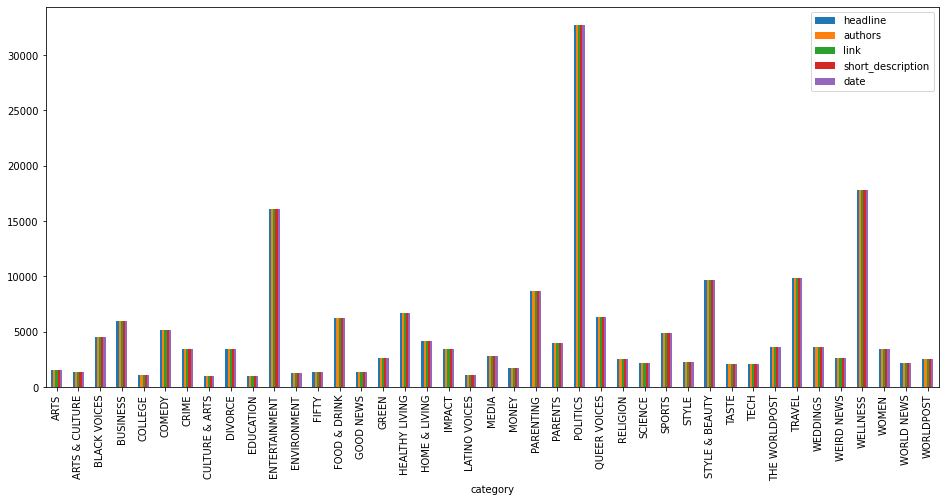

In [108]:
df.groupby(['category']).count().plot(kind = 'bar', figsize = (16, 7))
# Yeah, right. What a retarded plot.

In [109]:
# Preprocess the data.
# Is there any less retarded way?

df['category'].replace(['WELLNESS', 'HEALTHY LIVING', 'HOME & LIVING', 'STYLE & BEAUTY', 'STYLE'], 'LIFESTYLE AND WELLNESS', inplace=True)
df['category'].replace(['PARENTING', 'PARENTS', 'EDUCATION', 'COLLEGE'], 'PARENTING AND EDUCATION', inplace=True)
df['category'].replace(['SPORTS', 'ENTERTAINMENT', 'COMEDY', 'WEIRD NEWS', 'ARTS'], 'SPORTS AND ENTERTAINMENT', inplace=True)
df['category'].replace(['TRAVEL', 'ARTS & CULTURE', 'CULTURE & ARTS', 'FOOD & DRINK', 'TASTE'], 'TRAVEL-TOURISM & ART-CULTURE', inplace=True)
df['category'].replace(['WOMEN', 'QUEER VOICES', 'LATINO VOICES', 'BLACK VOICES'], 'EMPOWERED VOICES', inplace=True)
df['category'].replace(['BUSINESS',  'MONEY'], 'BUSINESS-MONEY', inplace=True)
df['category'].replace(['THE WORLDPOST', 'WORLDPOST', 'WORLD NEWS'], 'WORLDNEWS', inplace=True)
df['category'].replace(['ENVIRONMENT', 'GREEN'], 'ENVIRONMENT', inplace=True)
df['category'].replace(['TECH', 'SCIENCE'], 'SCIENCE AND TECH', inplace=True)
df['category'].replace(['FIFTY', 'IMPACT', 'GOOD NEWS', 'CRIME'], 'GENERAL', inplace=True)
df['category'].replace(['WEDDINGS', 'DIVORCE',  'RELIGION', 'MEDIA'], 'MISC', inplace=True)
# Merge the headline and the description, some of the crucial data may be present in either. 
df['text'] = df['headline'] + " " + df['short_description']


In [110]:
df['length'] = df['text'].str.len()
df['length'].describe()

count    200853.000000
mean        173.252991
std          79.869214
min           1.000000
25%         120.000000
50%         170.000000
75%         208.000000
max        1487.000000
Name: length, dtype: float64

Средняя длина текста составляет 173 символа, есть также текст размером в 1 символ. От таких данных необходимо избавиться. Точный threshold можно было бы определить, внимательнее посмотрев на данные, обойдёмся границей в 50 символов. Альтернативный вариант -- максимальный размер headline. 
Вполне вероятно, что в датасете также имеются и дубликаты, избавимся от них.

In [111]:
df.drop(df[df.length < 50].index, inplace = True)
df.drop_duplicates(subset = ['short_description'], inplace = True)
df.drop(columns = ['headline', 'authors', 'link', 'short_description', 'date', 'length'], inplace = True)
df.reset_index(drop = True, inplace = True)
df


,category,text
0,GENERAL,There Were 2 Mass Shootings In Texas Last Week...
1,SPORTS AND ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,SPORTS AND ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,SPORTS AND ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,SPORTS AND ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...
...,...,...
178209,SCIENCE AND TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...
178210,SPORTS AND ENTERTAINMENT,Maria Sharapova Stunned By Victoria Azarenka I...
178211,SPORTS AND ENTERTAINMENT,"Giants Over Patriots, Jets Over Colts Among M..."
178212,SPORTS AND ENTERTAINMENT,Aldon Smith Arrested: 49ers Linebacker Busted ...


Разобъём данные на выборки.
После очистки данных и выделения необходимых нам данных, разобъём на токены с помощью регулярного выражения и RegExpTokenizer.
Уберем лишние знаки препинания, URL, специальные символы для каждого текста. 

In [112]:
import multiprocessing as mp
import string
import swifter

nltk.download('stopwords')
tokenizer = nltk.RegexpTokenizer(r'\w+')

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def text_preprocess(text):
    # Remove the punctuation, URL-s, bracket-surrounded words, special symbols, etc.
    preprocessed = clean_text(text)
    # Tokenize with RegExpTokenizer -- everything else might be an overkill.
    preprocessed = tokenizer.tokenize(preprocessed)
    # Remove the stopwords (although they as well might carry the crucial information)
    stripped = [w for w in preprocessed if w not in stopwords.words('english')]
    preprocessed = ' '.join(stripped)
    return preprocessed

with mp.Pool(mp.cpu_count()) as pool:
    df['text'] = pool.map(text_preprocess, df['text'])

df


[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,category,text
0,GENERAL,mass shootings texas last week tv left husband...
1,SPORTS AND ENTERTAINMENT,smith joins diplo nicky jam world cups officia...
2,SPORTS AND ENTERTAINMENT,hugh grant marries first time age actor longti...
3,SPORTS AND ENTERTAINMENT,jim carrey blasts castrato adam schiff democra...
4,SPORTS AND ENTERTAINMENT,julianna margulies uses donald trump poop bags...
...,...,...
178209,SCIENCE AND TECH,rim ceo thorsten heins significant plans black...
178210,SPORTS AND ENTERTAINMENT,maria sharapova stunned victoria azarenka aust...
178211,SPORTS AND ENTERTAINMENT,giants patriots jets colts among improbable su...
178212,SPORTS AND ENTERTAINMENT,aldon smith arrested linebacker busted dui cor...


In [113]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    analyzer = 'word',
    ngram_range = (1, 3),
    dtype = numpy.float32
)

vectorized = vectorizer.fit_transform(df['text'])

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    vectorized, 
    df['category'], 
    test_size = 0.2, 
    random_state = 42
)

clf = sklearn.svm.LinearSVC(C = 1.0, loss = 'squared_hinge')
clf.fit(X_train, Y_train)
predictions = clf.predict(X_test)
print(accuracy_score(Y_test, predictions))

0.7168588502651292


Обычно, для SVM, большее количество сгенерированных n-gram-ов положительно влияет на точность обучения. Функция ошибки выбрана случайным образом.

                              precision    recall  f1-score   support

              BUSINESS-MONEY       0.66      0.49      0.56      1337
            EMPOWERED VOICES       0.70      0.50      0.58      2641
                 ENVIRONMENT       0.61      0.41      0.49       663
                     GENERAL       0.61      0.28      0.39      1540
      LIFESTYLE AND WELLNESS       0.71      0.88      0.79      7542
                        MISC       0.79      0.60      0.68      2212
     PARENTING AND EDUCATION       0.68      0.70      0.69      2756
                    POLITICS       0.74      0.84      0.79      5845
            SCIENCE AND TECH       0.68      0.39      0.49       720
    SPORTS AND ENTERTAINMENT       0.70      0.75      0.72      5001
TRAVEL-TOURISM & ART-CULTURE       0.76      0.79      0.78      3940
                   WORLDNEWS       0.74      0.65      0.69      1446

                    accuracy                           0.72     35643
                  

Text(0.5, 1.0, 'Confusion Matrix')

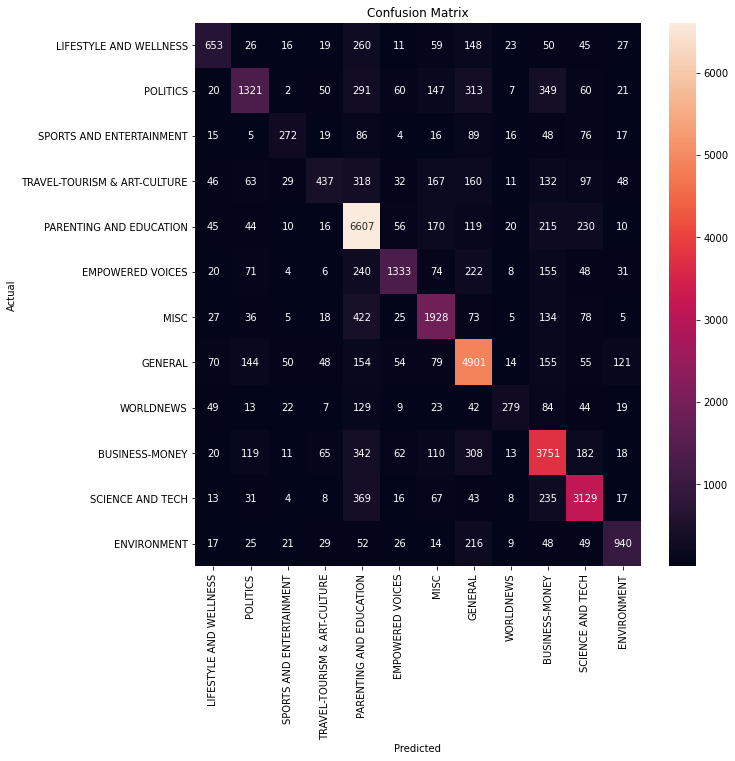

In [114]:
print(sklearn.metrics.classification_report(numpy.asarray(Y_test), numpy.asarray(predictions)))
cf_matrix = confusion_matrix(Y_test, predictions)

plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cf_matrix, xticklabels = df['category'].value_counts().index,
                      yticklabels = df['category'].value_counts().index,
                      annot = True, fmt = 'd', color = 'blue')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

Точность у LinearSVC нормальная, лучше, чем 50%. Подбор параметров с помощью классических методов, включая SVM, вряд ли даст значительное улучшение.
(по опыту, для текстов небольшой размерности лучше всего подходит SVM, либо ансамбль из SVM с разными фичами (напр. диакритические символы)). Для формальности, выведем результат для MultinomialNB.

In [115]:
clf = sklearn.naive_bayes.MultinomialNB()
clf.fit(X_train, Y_train)
predictions = clf.predict(X_test)
print(accuracy_score(Y_test, predictions))

0.44903627640770977


Теперь рассмотрим две модели нейронных сетей. Для начала рассмотрим базовую LSTM-модель с одним слоем, коэффициенты и количество нейронов на слое были выбраны случайным образом.

In [116]:
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Flatten
from keras.models import Sequential

SEQUENCE_PADDED_SIZE = 50

tokenizer = Tokenizer()

def get_word_sequences(texts):
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    return sequences

def get_embedding_layer(f):
    d = {}
    for line in f:
        string = line.split()
        word = string[0]
        values = numpy.asarray(string[1:], dtype='float32')
        d[word] = values
    matrix = numpy.zeros((len(tokenizer.word_index) + 1, 100))
    for w, i in tokenizer.word_index.items():
        v = d.get(w)
        if v is not None:
            matrix[i] = v
    return Embedding(len(tokenizer.word_index) + 1, 100, embeddings_initializer=Constant(matrix), input_length = SEQUENCE_PADDED_SIZE, trainable=False)

X = numpy.array(list(sequence.pad_sequences(get_word_sequences(df.text), maxlen = SEQUENCE_PADDED_SIZE)))
category_dict = dict((index, key) for key, index in enumerate(list(df.groupby('category').groups.keys())))
df['labels'] = df['category'].apply(lambda x: category_dict[x])
Y = np_utils.to_categorical(list(df.labels))
        
with open('glove.6B.100d.txt', 'r') as f: 
    layer = get_embedding_layer(f)

model = Sequential()
model.add(layer)
model.add(LSTM(300, dropout = 0.30, recurrent_dropout = 0.30))
model.add(Dropout(0.35))
model.add(Dense(256, activation = 'sigmoid'))
model.add(Dropout(0.35))
model.add(BatchNormalization())
model.add(Dense(len(category_dict), activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           10537100  
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               481200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 12)               

In [117]:
history = model.fit(X, Y, batch_size=128, validation_split = 0.4, epochs = 15)

Epoch 1/15
836/836 [==============================] - 86s 102ms/step - loss: 1.4731 - accuracy: 0.5388 - val_loss: 1.5376 - val_accuracy: 0.5232
Epoch 2/15
836/836 [==============================] - 84s 100ms/step - loss: 1.1651 - accuracy: 0.6214 - val_loss: 1.4482 - val_accuracy: 0.5567
Epoch 3/15
836/836 [==============================] - 85s 101ms/step - loss: 1.0917 - accuracy: 0.6423 - val_loss: 1.3858 - val_accuracy: 0.5728
Epoch 4/15
836/836 [==============================] - 83s 100ms/step - loss: 1.0405 - accuracy: 0.6594 - val_loss: 1.3005 - val_accuracy: 0.5994
Epoch 5/15
836/836 [==============================] - 85s 102ms/step - loss: 1.0059 - accuracy: 0.6675 - val_loss: 1.3663 - val_accuracy: 0.5795
Epoch 6/15
836/836 [==============================] - 85s 102ms/step - loss: 0.9798 - accuracy: 0.6762 - val_loss: 1.3199 - val_accuracy: 0.6040
Epoch 7/15
836/836 [==============================] - 84s 101ms/step - loss: 0.9553 - accuracy: 0.6823 - val_loss: 1.3022 - val_ac

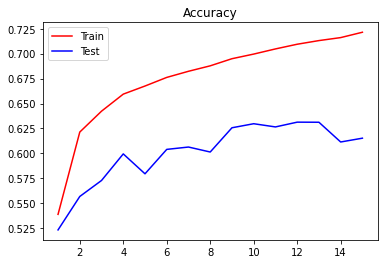

In [119]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.title('Accuracy')
plt.plot(epochs, acc, 'red', label='Train')
plt.plot(epochs, val_acc, 'blue', label='Test')
plt.legend()
plt.show()

**Выводы**
1. Для текстов небольших размеров, оптимально брать LinearSVC и его производные (напр. SVC + Linear Kernel). Можно было бы рассмотреть ансамбль из SVM для разных признаков. Для дополнительного подтверждения следовало бы взять набор из классических ML-методов и сравнить каждый.
2. Чаще всего, если набор данных открытый и не подготовлен заранее, он будет замусорен -- нужна первичная предобработка.
3. LSTM-сетка по val_accuracy оказалась хуже, чем SVC. Возможно, архитектуру следовало дополнить. Скорость работы оставляет желать лучшего.

**Заметки для себя**
1. Разобраться в векторном представлении данных (vectorizer, tf-idf, padding), LSTM-сетках для NLP
2. Попробовать GridSearch, пайплайнинг